In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

usedu_df = pd.read_sql_query('select * from useducation',con=engine)

# No need for an open connection, 
# because you're only doing a single query
engine.dispose()

In [13]:
# For easier programming we will convert all column heads to lowercase.
clean_usedu = usedu_df.copy()
clean_usedu.columns = clean_usedu.columns.str.lower()

#We need to fill missing values before handling outliers.
# You get the column names by using: 
#print(clean_usedu.columns)
fill_list = ['enroll', 'total_revenue', 'federal_revenue', 'state_revenue', 'local_revenue', 'total_expenditure', 
             'instruction_expenditure', 'support_services_expenditure', 'other_expenditure', 
             'capital_outlay_expenditure', 'grades_pk_g', 'grades_kg_g', 'grades_4_g', 'grades_8_g', 'grades_12_g', 
             'grades_1_8_g', 'grades_9_12_g', 'grades_all_g'] 
states = clean_usedu["state"].unique()
for state in states:
    clean_usedu.loc[clean_usedu["state"] == state, fill_list] == clean_usedu.loc[clean_usedu["state"] == state, fill_list].interpolate()

clean_usedu.dropna(inplace=True)

clean_usedu.head()

,primary_key,state,year,enroll,total_revenue,federal_revenue,state_revenue,local_revenue,total_expenditure,instruction_expenditure,...,grades_4_g,grades_8_g,grades_12_g,grades_1_8_g,grades_9_12_g,grades_all_g,avg_math_4_score,avg_math_8_score,avg_reading_4_score,avg_reading_8_score
209,1996_ALABAMA,ALABAMA,1996,"735,912.00","3,365,113.00","334,858.00","2,138,717.00","891,538.00","3,572,283.00","1,987,018.00",...,"57,098.00","58,305.00","42,510.00","469,370.00","207,980.00","686,983.00",211.65,256.59,210.92,260.28
211,1996_ARIZONA,ARIZONA,1996,"764,681.00","4,143,304.00","378,917.00","1,798,363.00","1,966,024.00","4,391,555.00","1,860,007.00",...,"62,793.00","60,514.00","42,041.00","511,925.00","210,289.00","726,709.00",217.58,267.87,206.53,263.28
212,1996_ARKANSAS,ARKANSAS,1996,"452,907.00","2,183,384.00","192,152.00","1,296,247.00","694,985.00","2,297,381.00","1,264,275.00",...,"33,855.00","37,064.00","27,613.00","283,883.00","131,997.00","417,860.00",215.85,261.65,208.84,271.83
213,1996_CALIFORNIA,CALIFORNIA,1996,"5,460,484.00","31,282,981.00","2,603,882.00","17,061,474.00","11,617,625.00","31,561,692.00","16,880,730.00",...,"435,217.00","406,456.00","298,669.00","3,516,572.00","1,525,618.00","5,115,423.00",209.13,262.77,201.91,269.20
214,1996_COLORADO,COLORADO,1996,"655,679.00","3,891,203.00","194,998.00","1,664,676.00","2,031,529.00","4,075,165.00","2,052,264.00",...,"52,524.00","52,269.00","37,179.00","423,510.00","185,700.00","621,730.00",225.81,275.61,221.65,268.17


# 1. Derive the descriptive statistics of the data and discuss the points you find remarkable.


In [12]:
pd.options.display.float_format = "{:,.2f}".format
clean_usedu.describe()

,year,enroll,total_revenue,federal_revenue,state_revenue,local_revenue,total_expenditure,instruction_expenditure,support_services_expenditure,other_expenditure,...,grades_4_g,grades_8_g,grades_12_g,grades_1_8_g,grades_9_12_g,grades_all_g,avg_math_4_score,avg_math_8_score,avg_reading_4_score,avg_reading_8_score
count,413.00,413.00,413.00,413.00,413.00,413.00,413.00,413.00,413.00,413.00,...,413.00,413.00,413.00,413.00,413.00,413.00,413.00,413.00,413.00,413.00
mean,"2,007.51","931,623.09","10,344,944.19","930,181.06","4,773,503.32","4,641,259.80","10,452,280.06","5,406,896.30","3,051,817.99","473,183.05",...,"71,371.50","72,044.10","63,246.94","575,617.42","282,126.46","879,940.15",236.64,279.55,219.33,263.57
std,5.25,"1,092,798.79","12,678,207.40","1,288,069.51","5,881,499.97","5,984,116.79","12,930,252.85","6,807,701.88","3,589,109.43","564,558.45",...,"83,930.73","83,803.41","73,955.46","675,717.07","330,537.08","1,032,313.67",9.01,9.62,7.59,6.95
min,"1,996.00","44,179.00","678,874.00","57,870.00",0.00,"28,531.00","703,245.00","318,260.00","204,117.00","23,107.00",...,"3,423.00","2,860.00","2,188.00","26,762.00","9,970.00","36,823.00",187.13,232.83,181.63,236.38
25%,"2,003.00","279,456.00","2,654,366.00","259,390.00","1,431,621.00","941,683.00","2,623,966.00","1,402,305.00","804,253.00","127,968.00",...,"20,480.00","20,834.00","18,519.00","166,618.00","81,809.00","259,417.00",231.95,274.31,214.93,259.42
50%,"2,007.00","665,109.00","6,029,807.00","535,223.00","2,962,151.00","2,342,892.00","6,175,724.00","3,166,208.00","1,856,055.00","323,913.00",...,"50,899.00","50,186.00","41,118.00","405,817.00","186,662.00","624,979.00",238.30,281.41,220.83,265.05
75%,"2,011.00","1,014,577.00","11,905,941.00","1,014,556.00","5,970,302.00","5,233,700.00","11,462,062.00","6,006,275.00","3,551,036.00","546,926.00",...,"79,078.00","80,850.00","74,749.00","638,447.00","321,313.00","968,731.00",242.66,286.10,224.51,268.20
max,"2,015.00","6,307,022.00","73,958,896.00","9,990,221.00","42,333,637.00","34,941,513.00","74,766,086.00","41,954,260.00","21,693,675.00","3,759,373.00",...,"493,415.00","500,143.00","498,403.00","3,929,869.00","2,011,865.00","5,926,631.00",253.42,300.57,236.77,277.19


1. Average TOTAL_REVENUE is less than TOTAL_EXPENDITURE. This means that states run budget deficit on education on average.

1. INSTRUCTION_EXPENDITURE makes up almost half of the total expenditures on education.

1. Average math scores are higher than average reading scores but the standard deviation of the average math scores is also higher than the that of the average reading scores.

# 2. Choose a state (such as California) and draw a line graph of its total revenues and total expenditures over the years. How do these two variables evolve during these years? Try to explain the peaks and troughs with some state-wise news and information around those dates.

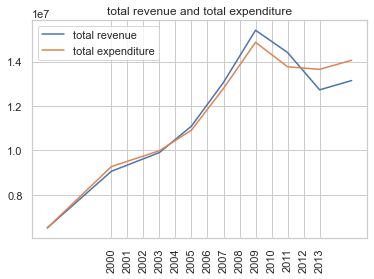

In [30]:
plt.plot(clean_usedu.loc[clean_usedu.state == "NORTH_CAROLINA", "year"],
        clean_usedu.loc[clean_usedu.state == "NORTH_CAROLINA", "total_revenue"], label = "total revenue")

plt.plot(clean_usedu.loc[clean_usedu.state == "NORTH_CAROLINA", "year"],
        clean_usedu.loc[clean_usedu.state == "NORTH_CAROLINA", "total_expenditure"], label = "total expenditure")

plt.title("total revenue and total expenditure")
plt.legend()
plt.xticks(range(2000, 2014), rotation=90)
plt.yticks()
plt.show()

# 3. In your chosen state, in which of the lessons are the students more successful—math or reading?

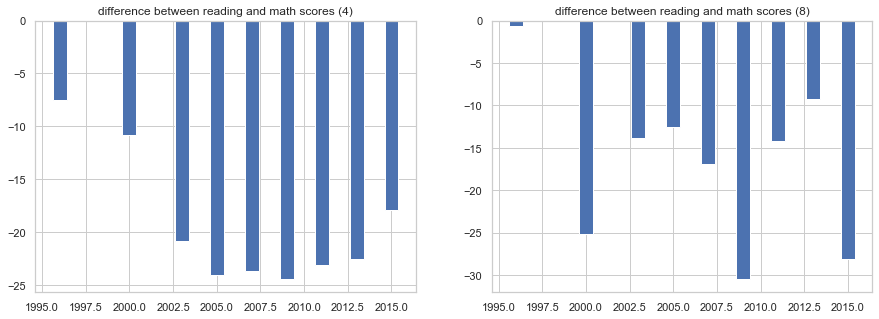

difference between reading and math scores (4)
242     -7.49
450    -10.83
606    -20.82
709    -24.10
814    -23.68
922    -24.48
1026   -23.16
1130   -22.57
1232   -17.93
dtype: float64
difference between reading and math scores (8)
242     -0.62
450    -25.11
606    -13.88
709    -12.60
814    -16.85
922    -30.49
1026   -14.19
1130    -9.27
1232   -28.10
dtype: float64


In [31]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.bar(clean_usedu.loc[clean_usedu.state == "NORTH_CAROLINA", "year"],
       clean_usedu.loc[clean_usedu.state == "NORTH_CAROLINA", "avg_reading_4_score"] - clean_usedu.loc[clean_usedu.state == "NORTH_CAROLINA", "avg_math_4_score"])

plt.title("difference between reading and math scores (4)")

plt.subplot(1,2,2)
plt.bar(clean_usedu.loc[clean_usedu.state == "NORTH_CAROLINA", "year"],
       clean_usedu.loc[clean_usedu.state == "NORTH_CAROLINA", "avg_reading_8_score"] - clean_usedu.loc[clean_usedu.state == "NORTH_CAROLINA", "avg_math_8_score"])

plt.title("difference between reading and math scores (8)")

plt.show()

print("difference between reading and math scores (4)")
print(clean_usedu.loc[clean_usedu.state == "NORTH_CAROLINA", "avg_reading_4_score"] - clean_usedu.loc[clean_usedu.state == "NORTH_CAROLINA", "avg_math_4_score"])
print("difference between reading and math scores (8)")
print(clean_usedu.loc[clean_usedu.state == "NORTH_CAROLINA", "avg_reading_8_score"] - clean_usedu.loc[clean_usedu.state == "NORTH_CAROLINA", "avg_math_8_score"])


In NC, students are more successful at math than reading.

# 4. What are the distributions of the math and reading scores in the sample?

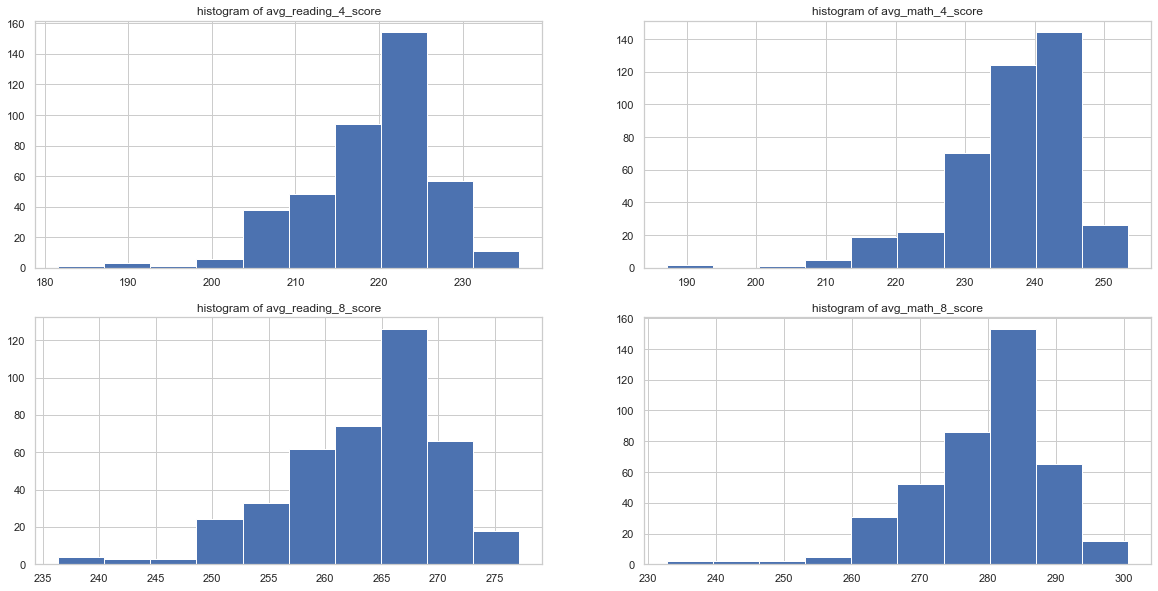

In [33]:

plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.hist(clean_usedu.avg_reading_4_score.dropna())
plt.title("histogram of {}".format("avg_reading_4_score"))

plt.subplot(2,2,2)
plt.hist(clean_usedu.avg_math_4_score.dropna())
plt.title("histogram of {}".format("avg_math_4_score"))

plt.subplot(2,2,3)
plt.hist(clean_usedu.avg_reading_8_score.dropna())
plt.title("histogram of {}".format("avg_reading_8_score"))

plt.subplot(2,2,4)
plt.hist(clean_usedu.avg_math_8_score.dropna())
plt.title("histogram of {}".format("avg_math_8_score"))
plt.show()

The distributions are not normal distribution but slightly skewed to the left both for reading and writing. This means that average of the scores are lower than the median.

# 5. Now, look again at the original dataset (before you filled in the missing values). Notice there are too many missing values for math and reading scores. Fill out the missing values using mean, median, and linear interpolation. Then, compare the effects of these techniques on the distributions of the score variables.

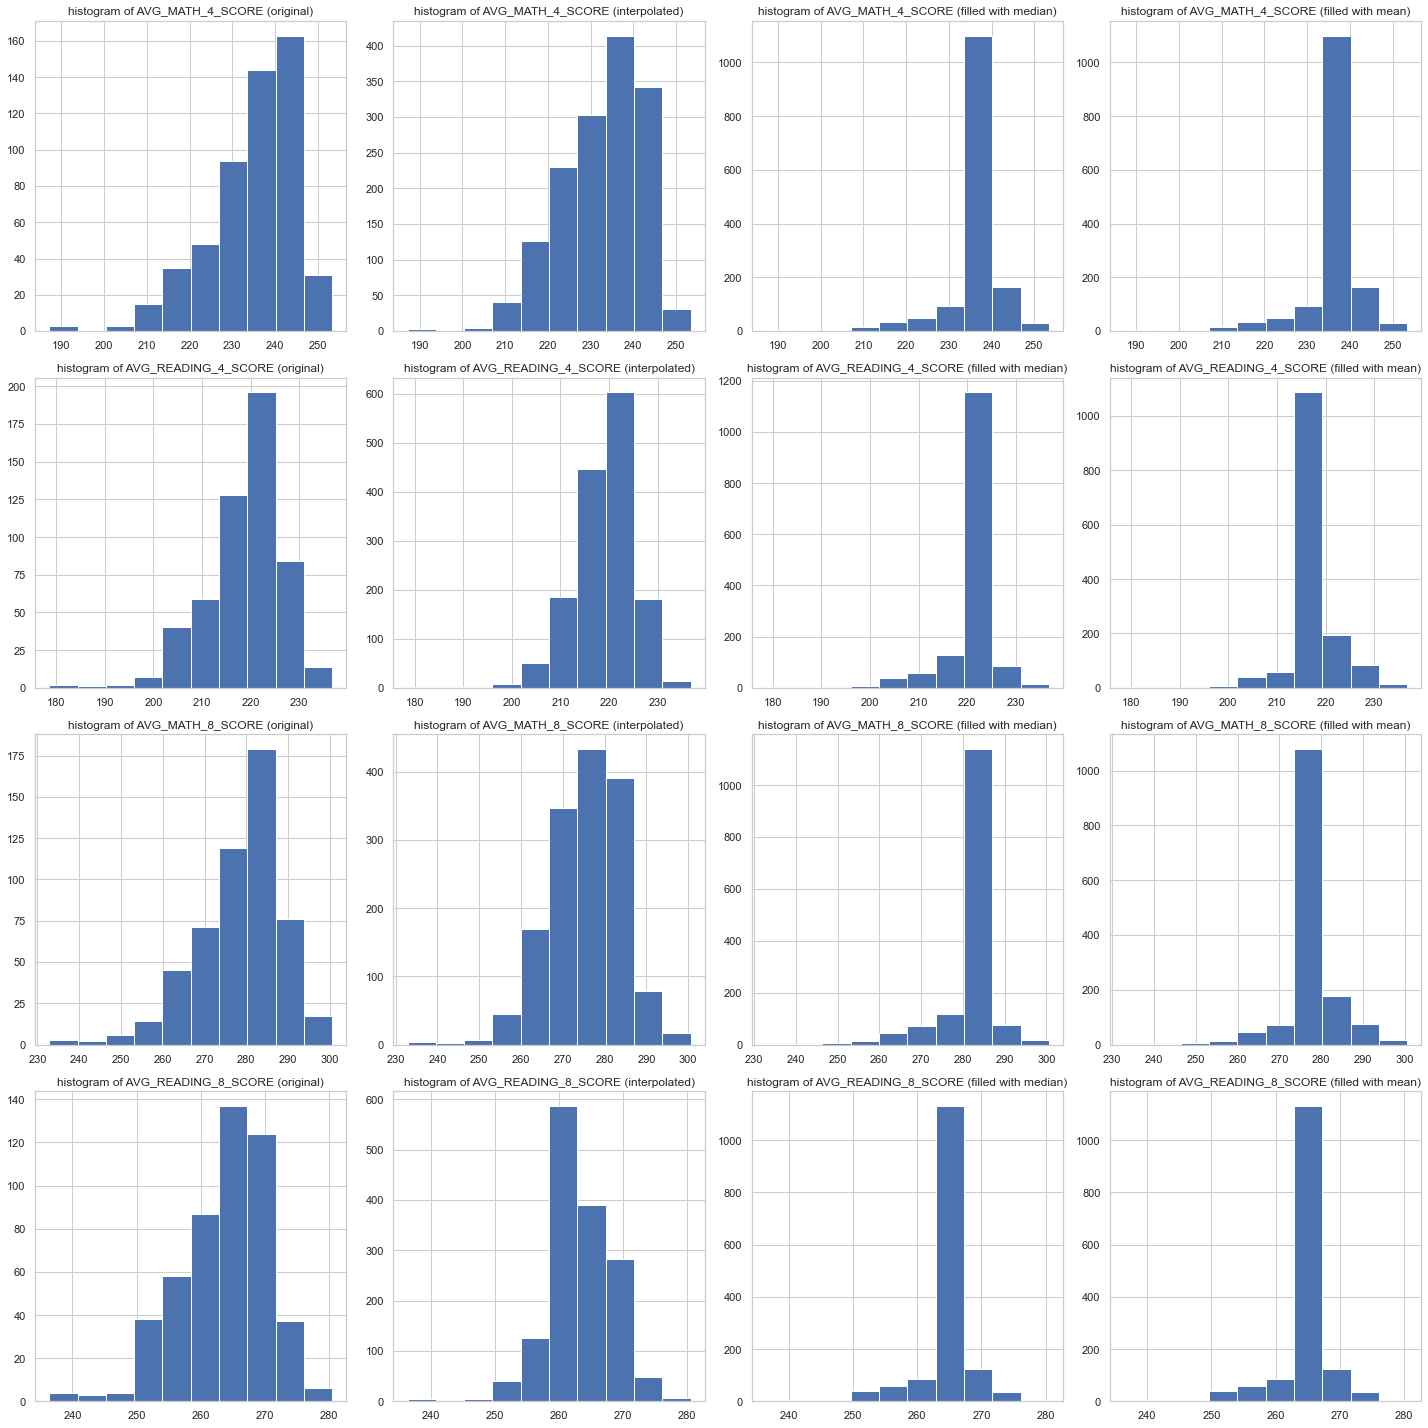

In [34]:
plt.figure(figsize=(20,20))

plt.subplot(4,4,1)
plt.hist(usedu_df.AVG_MATH_4_SCORE.dropna())
plt.title("histogram of {} (original)".format("AVG_MATH_4_SCORE"))

plt.subplot(4,4,2)
plt.hist(usedu_df.AVG_MATH_4_SCORE.interpolate())
plt.title("histogram of {} (interpolated)".format("AVG_MATH_4_SCORE"))

plt.subplot(4,4,3)
plt.hist(usedu_df.AVG_MATH_4_SCORE.fillna(usedu_df.AVG_MATH_4_SCORE.median()))
plt.title("histogram of {} (filled with median)".format("AVG_MATH_4_SCORE"))

plt.subplot(4,4,4)
plt.hist(usedu_df.AVG_MATH_4_SCORE.fillna(usedu_df.AVG_MATH_4_SCORE.mean()))
plt.title("histogram of {} (filled with mean)".format("AVG_MATH_4_SCORE"))

plt.subplot(4,4,5)
plt.hist(usedu_df.AVG_READING_4_SCORE.dropna())
plt.title("histogram of {} (original)".format("AVG_READING_4_SCORE"))

plt.subplot(4,4,6)
plt.hist(usedu_df.AVG_READING_4_SCORE.interpolate())
plt.title("histogram of {} (interpolated)".format("AVG_READING_4_SCORE"))

plt.subplot(4,4,7)
plt.hist(usedu_df.AVG_READING_4_SCORE.fillna(usedu_df.AVG_READING_4_SCORE.median()))
plt.title("histogram of {} (filled with median)".format("AVG_READING_4_SCORE"))

plt.subplot(4,4,8)
plt.hist(usedu_df.AVG_READING_4_SCORE.fillna(usedu_df.AVG_READING_4_SCORE.mean()))
plt.title("histogram of {} (filled with mean)".format("AVG_READING_4_SCORE"))

plt.subplot(4,4,9)
plt.hist(usedu_df.AVG_MATH_8_SCORE.dropna())
plt.title("histogram of {} (original)".format("AVG_MATH_8_SCORE"))

plt.subplot(4,4,10)
plt.hist(usedu_df.AVG_MATH_8_SCORE.interpolate())
plt.title("histogram of {} (interpolated)".format("AVG_MATH_8_SCORE"))

plt.subplot(4,4,11)
plt.hist(usedu_df.AVG_MATH_8_SCORE.fillna(usedu_df.AVG_MATH_8_SCORE.median()))
plt.title("histogram of {} (filled with median)".format("AVG_MATH_8_SCORE"))

plt.subplot(4,4,12)
plt.hist(usedu_df.AVG_MATH_8_SCORE.fillna(usedu_df.AVG_MATH_8_SCORE.mean()))
plt.title("histogram of {} (filled with mean)".format("AVG_MATH_8_SCORE"))

plt.subplot(4,4,13)
plt.hist(usedu_df.AVG_READING_8_SCORE.dropna())
plt.title("histogram of {} (original)".format("AVG_READING_8_SCORE"))

plt.subplot(4,4,14)
plt.hist(usedu_df.AVG_READING_8_SCORE.interpolate())
plt.title("histogram of {} (interpolated)".format("AVG_READING_8_SCORE"))

plt.subplot(4,4,15)
plt.hist(usedu_df.AVG_READING_8_SCORE.fillna(usedu_df.AVG_READING_8_SCORE.median()))
plt.title("histogram of {} (filled with median)".format("AVG_READING_8_SCORE"))

plt.subplot(4,4,16)
plt.hist(usedu_df.AVG_READING_8_SCORE.fillna(usedu_df.AVG_READING_8_SCORE.mean()))
plt.title("histogram of {} (filled with mean)".format("AVG_READING_8_SCORE"))

plt.tight_layout()
plt.show()

The technique for filling in the missing values substantially affects the distributions of the variables. Especially in our case, filling with mean or median has the strongest effect. This is probably due to the fact that we have a lot of missing values in our data.

The change in the distribution might have some serious effects on our model results. Hence, instead of filling in the missing values with mean or median, we may fill them in using interpolation or we may just discard the missing values.